# logit-lens

> Module the implements [the logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens),  a way of interpreting the intermediate layers of a transformer. 

In [ ]:
#| default_exp experiments.logit_lens

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from typing import Optional

In [ ]:
#| export
import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import torch

In [ ]:
#| export 
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer_helpers import (
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors,
)
from transformer_experiments.tokenizers.char_tokenizer import CharacterTokenizer
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer, 
)

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from fastcore.test import *

In [ ]:
# | export
class LogitLens:
    def __init__(
        self,
        eh: EncodingHelpers,
        accessors: TransformerAccessors,
        prompt: str,
        correct: str,
    ):
        self.eh = eh
        self.accessors = accessors
        self.prompt = prompt
        self.correct = correct

        assert len(prompt) == len(correct), "prompt and correct must be the same length"

        prompt_tokens = eh.tokenize_string(prompt)
        x = eh.embed_tokens(prompt_tokens)
        _, io_accessors = accessors.run_model(x)

        self.embeddings = [x]  # List of embeddings starts with the input
        # Add the outputs of each block
        self.embeddings.extend(
            [io_accessor.output('.') for io_accessor in io_accessors]
        )

        # Now we have a list of (1 + n_layer) embeddings tensors.
        # Each embedding tensor has shape (1, len(prompt), n_embed).
        # We'll now want to build two lists, each with (1 + n_layer)
        # entries:
        #  - top_tokens: each entry is a list of length len(prompt) that
        #                contains the top token predicted at each position
        #  - top_token_probs: each entry is a list of length len(prompt) that
        #                     contains the probability of the top token at
        #                     each position
        top_tokens = []
        top_token_probs = []
        for emb in self.embeddings:
            logits = LogitsWrapper(accessors.logits_from_embedding(emb), self.eh.tokenizer)
            topk = logits.topk_tokens(1)

            # topk is shaped like this:
            # [  <- batch dimension
            #   [  <- prompt length dimension
            #     [  (token, prob) ], <- topk dimension (only 1 entry because we 
            #     [  (token, prob) ],    asked for the top 1 token)
            #     ...
            #   ]
            # ]
            #
            # We want to flatten this to just a list of len(prompt) of tokens 
            # and probs:
            #
            # [ (token, prob), (token, prob), ...)]
            # <---------- len(prompt) ----------->
            #
            # We know we have only one batch, so we just need to look at topk[0],
            # and then pull out the first item of each element. 
            tokens_and_probs = [item[0] for item in topk[0]]

            # Now separate the tokens and probs into separate lists
            tokens, probs = zip(*tokens_and_probs)

            top_tokens.append(list(tokens))
            top_token_probs.append(list(probs))

        self.top_tokens = top_tokens
        self.top_token_probs = top_token_probs

    def plot(self, ax: Optional[Axes] = None):
        # Reverse the order of the data so that the input is at the bottom
        # and the layers proceed upwards.
        top_tokens = list(reversed(self.top_tokens))
        top_token_probs = list(reversed(self.top_token_probs))

        nx = len(self.prompt)
        ny = len(self.top_tokens)

        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(1.2 * nx, 20))

        im = ax.imshow(top_token_probs, cmap='viridis')
        ax.set_xticks(range(nx))
        ax.set_xticklabels([repr(c)[1:-1] for c in self.prompt], fontsize=16)

        ax.set_yticks(range(ny))
        ax.set_yticklabels([f"Block {i - 1}" for i in range(ny - 1, 0, -1)] + ['Input'])

        ax_top = ax.secondary_xaxis('top')
        ax_top.set_xticks(range(nx))
        ax_top.set_xticklabels([repr(c)[1:-1] for c in self.correct], fontsize=16)

        im.set_clim(vmin=0, vmax=1)
        plt.colorbar(im, ax=[ax], location='top')

        for y in range(ny):
            for x in range(nx):
                fontweight = 'bold' if top_tokens[y][x] == self.correct[x] else None
                plt.text(
                    x,
                    y,
                    top_tokens[y][x],
                    ha='center',
                    fontweight=fontweight,
                    fontsize=16,
                )

In [ ]:
def get_fragment_and_correct(data: torch.Tensor, tokenizer: CharacterTokenizer, fragment_size=16, start_idx=0):
    """Return a fragment from a given corpus and the "correct" values for
    the next token at each position."""
    input = data[start_idx : start_idx + fragment_size]
    correct = data[start_idx + 1 : start_idx + fragment_size + 1]

    return tokenizer.decode(input.tolist()), tokenizer.decode(correct.tolist())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device is {device}")

device is cpu


In [ ]:
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9)
encoding_helpers = EncodingHelpers(m, tokenizer, device)
accessors = TransformerAccessors(m)

In [ ]:
prompt, correct = get_fragment_and_correct(val_data, tokenizer, start_idx=50)
print(f"INPUT  : {repr(prompt)}"), 
print(f"CORRECT: {repr(correct)}")

INPUT  : 'STA:\nGood morrow'
CORRECT: 'TA:\nGood morrow,'


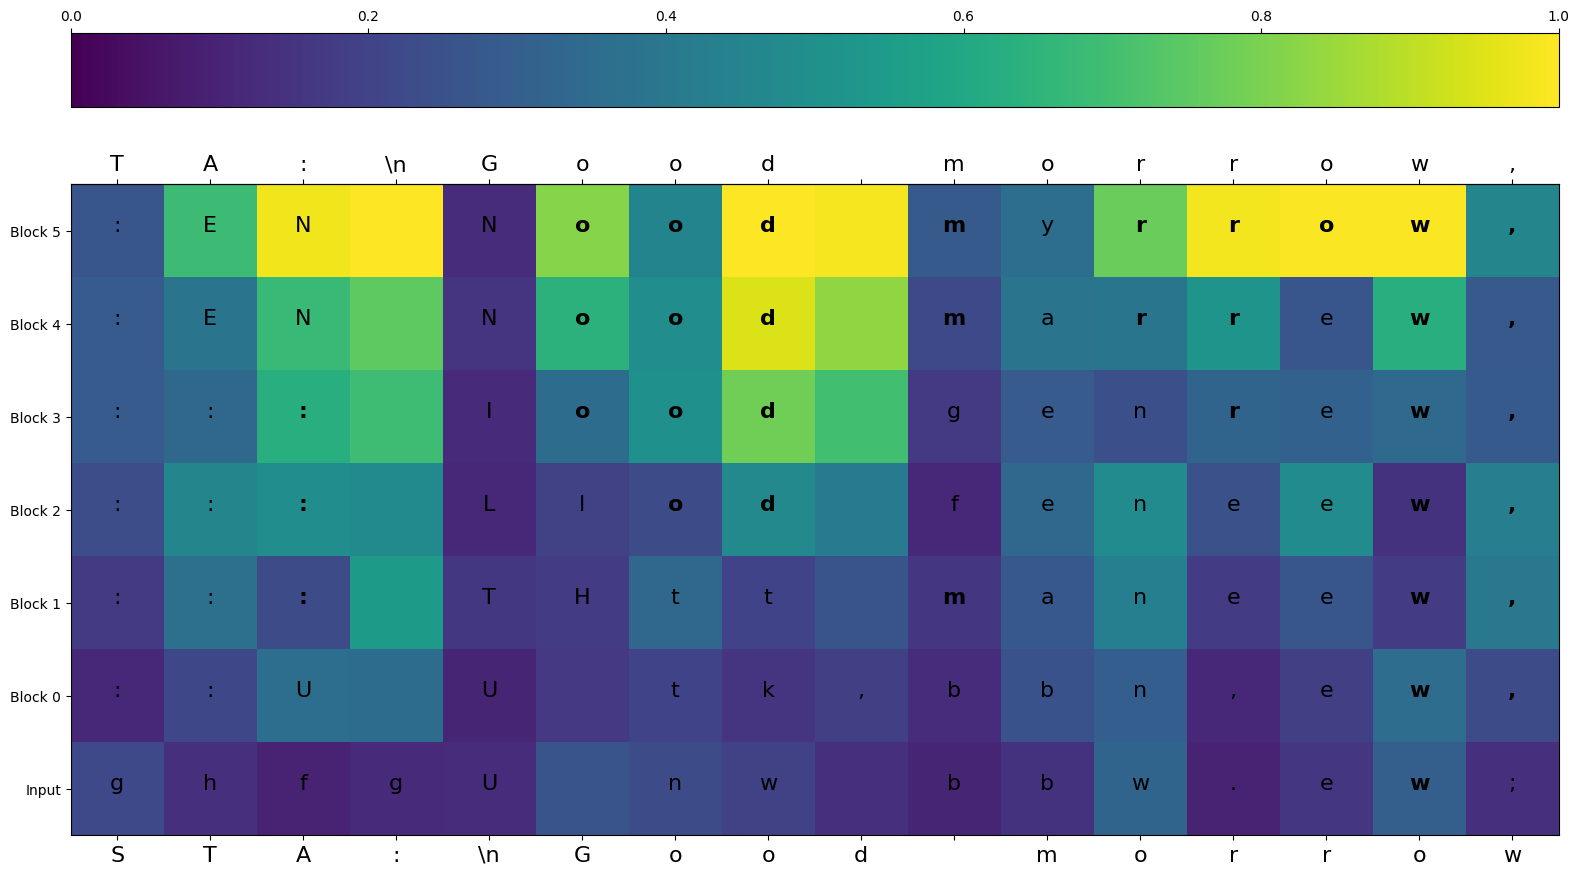

In [ ]:
logit_lens = LogitLens(encoding_helpers, accessors, prompt, correct)
logit_lens.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()